# Project 4 - Soccer Score Prediction

In [507]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [508]:
spi_global_rankings = pd.read_csv('../data/spi_global_rankings.csv')
spi_matches = pd.read_csv('../data/spi_matches.csv')

## SPI Global Rankings

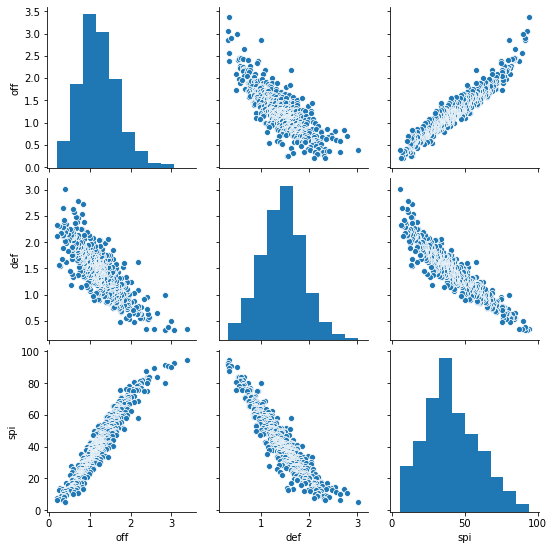

In [509]:
sns.pairplot(spi_global_rankings[['off', 'def', 'spi']])

### Distribution <font style='font-weight:normal;'>(off, def, and spi)</font>
Offensive, defensive and SPI ratings are skewed to the left. This means that most of the teams have below average ratings. So, we can say that the dataset contains a higher number of teams with low ratings. At the same time, there are very few teams with very high ratings.


### Correlation <font style='font-weight:normal;'>(off with spi, and def with spi)</font>
From the above pairplots, we can clearly see a positive correlation between spi and offensive rating. Also, we can find a negative correlation between spi and defensive rating. This goes to say that the more offensive a team plays, the higher its soccer power index and thus the higher their chances of winning.
***

## SPI Matches

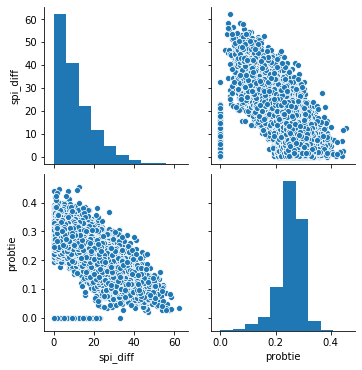

In [510]:
spi_matches['spi_diff'] = abs(spi_matches['spi1'] - spi_matches['spi2'])

sns.pairplot(spi_matches[['spi_diff', 'probtie']])

The probability of tie is very conservative even after boosting from the Poisson distribution [1]. The tie probability hardly goes up to 0.5. This is reasonable as a low probability of tie gives more concrete predictions.

### Correlation <font style='font-weight:normal;'>(probtie with spi_diff)</font>
The computed spi differences between the two teams are somewhat correlated with the probability of tie.

***

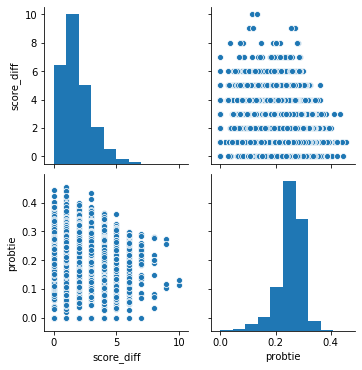

In [511]:
spi_matches['score_diff'] = abs(spi_matches['score1'] - spi_matches['score2'])

sns.pairplot(spi_matches[['score_diff', 'probtie']])

### Correlation <font style='font-weight:normal;'>(probtie with score_diff)</font>
However, even if we found somewhat of a correlation between the spi differences and the probability of a tie, the actual probability of tie is similary distributed across different score differences. The ideal situation would have been to have a high probtie for only the score difference of 0 (real tie). But, we have other score differences with high rate of tie probability. 
***

## Feature Engineering

#### Dropping tuples with nan values for score1 and score2

In [512]:
spi_matches.dropna(subset=['score1', 'score2'], inplace=True)

#### Scaling

In [513]:
scaler = MinMaxScaler()

spi_matches[['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'importance1', 'importance2']] = MinMaxScaler().fit_transform(spi_matches[['spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'importance1', 'importance2']])

#### Label Encoding Teams

In [514]:
labelEncoder = LabelEncoder()

spi_matches['team1'] = labelEncoder.fit_transform(spi_matches['team1'])
spi_matches['team2'] = labelEncoder.fit_transform(spi_matches['team2'])

#### Imputing importance missing values

In [515]:
spi_matches['importance1'] = spi_matches['importance1'].fillna(spi_matches['importance1'].mean())
spi_matches['importance2'] = spi_matches['importance2'].fillna(spi_matches['importance2'].mean())

#### Removing Outliers

In [516]:
spi_matches[['score1', 'score2']].describe()

,score1,score2
count,34287.000000,34287.000000
mean,1.523230,1.181760
std,1.282744,1.142315
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,11.000000,9.000000


Based on the statistics of the score1 and score2 column, we can see that the max values are far away from the mean. These can be categorized as outliers. We can safely remove the tuples having score1 or score2 value 3 standard deviation away from the mean. In this case, I have chosen to remove the tuples having either score1 or score2 above 5.

In [ ]:
spi_matches.drop(spi_matches[(spi_matches['score1']>5) | (spi_matches['score2']>5)].index, inplace=True)
spi_matches = spi_matches.reset_index()
spi_matches.drop(['index'], axis=1)

#### Feature creation through interaction

In [518]:
spi_matches['spi1_rel'] = (spi_matches['prob1'])*(1-spi_matches['probtie'])*(spi_matches['spi1']+0.001)/(spi_matches['spi2']+0.001)
spi_matches['spi2_rel'] = (spi_matches['prob2'])*(1-spi_matches['probtie'])*(spi_matches['spi2']+0.001)/(spi_matches['spi1']+0.001)

Here, I am creating a realtive spi metric for each team with respect to the opponent team. I am also factoring in the probability of winning and the probability of not having a tie. I add 0.001 to the numerator and denominator to avoid division by zero.

#### Polynomial Features, PCA, and Scaling generated features

In [ ]:
poly = PolynomialFeatures(2)
X_poly_features = poly.fit_transform(spi_matches[['team1', 'team2', 'spi1_rel', 'spi2_rel', 'proj_score1', 'proj_score2', 'importance1', 'importance2']])

pca = PCA(n_components=20)
X_poly_features = pca.fit_transform(X_poly_features)

scaler = MinMaxScaler()
X_poly_features = pd.DataFrame(scaler.fit_transform(X_poly_features), index=spi_matches.index)
 
X_poly_features.fillna(0)

## Regression

In [531]:
X = spi_matches[['team1', 'team2', 'spi1_rel', 'spi2_rel', 'proj_score1', 'proj_score2']]
y = spi_matches[['score1', 'score2']]

X_train, X_test, y_train, y_test = train_test_split(X_poly_features, y)

#### XGBoost

In [532]:
xgbRegressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=10, learning_rate=0.01))

xgbRegressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.01,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='reg:squarederror',
                                            r

In [533]:
y_pred = xgbRegressor.predict(X_test)

In [534]:
score = r2_score(y_test, y_pred)

print(score)

0.06133572327041853


#### Linear Regression

In [535]:
multiOutputRegressor = MultiOutputRegressor(Ridge(random_state=123))

multiOutputRegressor.fit(X_train, y_train)

MultiOutputRegressor(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=123, solver='auto',
                                     tol=0.001),
                     n_jobs=None)

In [536]:
y_pred = multiOutputRegressor.predict(X_test)

In [537]:
score = r2_score(y_test, y_pred)

print(score)

0.06753813524333041


#### Neural Network (Multi-layer Perceptron) Regression

In [538]:
mlpRegressor = MLPRegressor(random_state=0, max_iter=1000, learning_rate_init=0.01)

mlpRegressor.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.01, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=0, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [539]:
y_pred = mlpRegressor.predict(X_test)

In [540]:
score = r2_score(y_test, y_pred)

print(score)

0.07432247918631169


## Analysis

The XGBRegressor, Multioutput Regressor and MLPRegressor could not gave promising results as the r2_score was very poor. The feature space doesn't seem to have much correlation with the output. Additional feature engineering can improve the situation.

Although I have tried various other feature transformations with inter-feature interactions, the performance didn't seem to improve at all. I had also tried the Polynomial Feature generator from sklearn. Then, I used PCA to reduce features so that we didn't have curse of dimensionality. But, even with these additional features, performance didn't seem to improve. I believe, the key to eliciting a good linear correlation between the feature space and the target variable could be through using a linear combination of features.

### References

[1] https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/

[2] https://www.espn.com/world-cup/story/_/id/4447078/ce/us/guide-espn-spi-ratings